# Hourly AP Graphs
Aquest notebook crea un graf (NetworkX) per cada hora de cada dia on cada node és un AP.
Cada node porta dues ponderacions: la qualitat mitjana dels registres (avg_signal_db) i el número de registres (conn_count).
- La mida del node es basa en `conn_count`.
- El color del node reflecteix la qualitat normalitzada (`avg_signal_db`, escala [0,1], valors més elevats = millor qualitat).

S'espera que el notebook reutilitzi les utilitats de `starter_kits/utils/data_loader.py` (ja presents al repo).

In [1]:
# Imports i configuració bàsica
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
plt.rcParams.update({'figure.figsize': (10, 8)})

# Accedir a les utilitats ja existents
import sys
UTILS_PATH = Path('../starter_kits/utils').resolve()
if str(UTILS_PATH) not in sys.path:
    sys.path.append(str(UTILS_PATH))
from data_loader import load_multiple_files, load_clients, load_aps

In [2]:
# Carpeta d'entrada i sortida
BASE = Path('../realData')
CLIENTS_DIR = BASE / 'clients'
APS_DIR = BASE / 'ap'
OUT_DIR = Path('pabloCalo/output/hourly_graphs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Carregar dades (pots posar max_files per proves)
print('Carregant clients...')
df_clients = load_clients(CLIENTS_DIR, max_files=None, verbose=True)
print('Carregant APs (metadades)...')
df_aps = load_aps(APS_DIR, max_files=None, verbose=True)

# Assegurar timestamps i columnes auxiliars
if 'timestamp' not in df_clients.columns and 'last_connection_time' in df_clients.columns:
    df_clients['timestamp'] = pd.to_datetime(df_clients['last_connection_time'], unit='ms')

# Afegir date i hour per agrupar
df_clients['date'] = df_clients['timestamp'].dt.date
df_clients['hour'] = df_clients['timestamp'].dt.hour

# Nom de l'AP a clients (consistent amb el notebook referenciat)
AP_NAME_COL = 'associated_device_name'

# Merge amb metadades d'APs per obtenir camps com group_name/site si estan
if 'name' in df_aps.columns:
    df_meta = df_aps[['name', 'group_name', 'site']].drop_duplicates(subset=['name'])
    df_clients = df_clients.merge(df_meta, left_on=AP_NAME_COL, right_on='name', how='left')
else:
    df_clients['group_name'] = None
    df_clients['site'] = None

print('Dades preparades: clients:', len(df_clients), 'cols:', df_clients.columns.tolist())

Carregant clients...
📁 Encontrados 258 archivos en ../realData/clients
📊 Cargando todos archivos...
   Procesados 10/258 archivos... (11519 registros)
   Procesados 10/258 archivos... (11519 registros)
   Procesados 20/258 archivos... (116418 registros)
   Procesados 20/258 archivos... (116418 registros)
   Procesados 30/258 archivos... (250458 registros)
   Procesados 30/258 archivos... (250458 registros)
   Procesados 40/258 archivos... (328784 registros)
   Procesados 50/258 archivos... (337106 registros)
   Procesados 40/258 archivos... (328784 registros)
   Procesados 50/258 archivos... (337106 registros)
   Procesados 60/258 archivos... (411981 registros)
   Procesados 60/258 archivos... (411981 registros)
   Procesados 70/258 archivos... (528889 registros)
   Procesados 70/258 archivos... (528889 registros)
   Procesados 80/258 archivos... (599936 registros)
   Procesados 90/258 archivos... (610104 registros)
   Procesados 80/258 archivos... (599936 registros)
   Procesados 90/2

## Funcions auxiliars
Funcions per calcular mètriques per AP per bloc de temps i dibuixar/guardar el graf.

In [3]:
def norm01(series):
    s = series.astype(float).copy()
    if s.empty:
        return s
    mn, mx = s.min(), s.max()
    if pd.isna(mn) or pd.isna(mx) or mx - mn == 0:
        return pd.Series(0.5, index=s.index)
    return (s - mn) / (mx - mn)

import re
def get_building_from_name(ap_name):
    """Extrae el codi d'edifici del nom de l'AP (ex: 'AP-VET71' -> 'VET')."""
    if not isinstance(ap_name, str):
        return None
    m = re.match(r'^AP-([A-Za-z]+)', ap_name)
    return m.group(1) if m else None


def build_graph_and_plot(df_hour, out_path, date_str, hour, nodes_filter=None, prefix='ALL', group_level=False):
    """Construeix un graf on cada node és un AP o un edifici (si group_level=True) amb atributs:
    - conn_count: nombre de registres en aquest hour-block
    - avg_signal_db: qualitat mitjana (dBm)

    Si nodes_filter és una llista de noms d'AP, només es dibuixen aquests APs.
    Si group_level=True, s'agrupa per edifici (codi extret del nom de l'AP) i es dibuixen nodes d'edifici.
    Guarda la figura PNG a out_path.
    """
    if group_level:
        # Map AP -> building and aggregate per building
        df_build = df_hour.copy()
        df_build['building'] = df_build[AP_NAME_COL].apply(get_building_from_name)
        df_build = df_build.dropna(subset=['building'])
        if df_build.empty:
            return None
        metrics = (
            df_build.groupby('building')
                    .agg(conn_count=('macaddr', 'count'), avg_signal_db=('signal_db', 'mean'))
                    .reset_index()
                    .rename(columns={'building': AP_NAME_COL})
        )
    else:
        # Agregar per AP
        metrics = (
            df_hour.groupby(AP_NAME_COL)
                   .agg(conn_count=('macaddr', 'count'), avg_signal_db=('signal_db', 'mean'))
                   .reset_index()
        )

    if nodes_filter is not None and not group_level:
        metrics = metrics[metrics[AP_NAME_COL].isin(nodes_filter)].reset_index(drop=True)
    if metrics.empty:
        return None

    # Normalitzar qualitat (més alt = millor). avg_signal_db acostuma a ser negatiu (dBm), però això funciona:
    metrics['quality_norm'] = norm01(metrics['avg_signal_db'])
    metrics['size'] = (metrics['conn_count'] - metrics['conn_count'].min()).replace(0, 1) + 10

    # Crear graf i afegir nodes amb atributs
    G = nx.Graph()
    for _, row in metrics.iterrows():
        node_name = row[AP_NAME_COL]
        G.add_node(node_name, conn_count=int(row['conn_count']), avg_signal_db=float(row['avg_signal_db']), quality_norm=float(row['quality_norm']))

    # Afegir arestes segons group_name o site per donar estructura visual (si existeix la informació)
    # Si estem en nivell grup, connectem edificis que comparteixen group_name/site
    if group_level:
        if 'group_name' in df_hour.columns and df_hour['group_name'].notna().any():
            grouped = df_hour.copy()
            grouped['building'] = grouped[AP_NAME_COL].apply(get_building_from_name)
            grouped = grouped.dropna(subset=['building']).groupby('group_name')['building'].unique()
            for grp, buildings in grouped.items():
                b_list = [b for b in buildings if b in G.nodes]
                if len(b_list) > 1:
                    for i in range(len(b_list)):
                        for j in range(i + 1, len(b_list)):
                            if not G.has_edge(b_list[i], b_list[j]):
                                G.add_edge(b_list[i], b_list[j])
        elif 'site' in df_hour.columns and df_hour['site'].notna().any():
            grouped = df_hour.copy()
            grouped['building'] = grouped[AP_NAME_COL].apply(get_building_from_name)
            grouped = grouped.dropna(subset=['building']).groupby('site')['building'].unique()
            for site, buildings in grouped.items():
                b_list = [b for b in buildings if b in G.nodes]
                if len(b_list) > 1:
                    for i in range(len(b_list)):
                        for j in range(i + 1, len(b_list)):
                            if not G.has_edge(b_list[i], b_list[j]):
                                G.add_edge(b_list[i], b_list[j])
    else:
        # Connect APs by group_name/site as before
        if 'group_name' in df_hour.columns and df_hour['group_name'].notna().any():
            grouped = df_hour.groupby('group_name')[AP_NAME_COL].unique()
            for grp, aps in grouped.items():
                aps = [a for a in aps if a in G.nodes]
                if len(aps) > 1:
                    for i in range(len(aps)):
                        for j in range(i + 1, len(aps)):
                            if not G.has_edge(aps[i], aps[j]):
                                G.add_edge(aps[i], aps[j])
        elif 'site' in df_hour.columns and df_hour['site'].notna().any():
            grouped = df_hour.groupby('site')[AP_NAME_COL].unique()
            for site, aps in grouped.items():
                aps = [a for a in aps if a in G.nodes]
                if len(aps) > 1:
                    for i in range(len(aps)):
                        for j in range(i + 1, len(aps)):
                            if not G.has_edge(aps[i], aps[j]):
                                G.add_edge(aps[i], aps[j])

    # Layout: spring layout amb seed per reproduïbilitat
    pos = nx.spring_layout(G, seed=42)

    # Preparar arrays per al plot
    idxed = metrics.set_index(AP_NAME_COL)
    node_sizes = [idxed.loc[n, 'size'] * 20 if n in idxed.index else 50 for n in G.nodes()]
    node_colors = [idxed.loc[n, 'quality_norm'] if n in idxed.index else 0.5 for n in G.nodes()]

    fig, ax = plt.subplots(figsize=(12, 9))
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.3)
    sc = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap='viridis', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, alpha=0.9)

    cbar = plt.colorbar(sc, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Quality (norm, higher = better)')

    # Formatar etiqueta d'hora de manera segura (pot ser float/NaN)
    try:
        hour_int = int(hour)
        hour_label = f"{hour_int:02d}"
    except Exception:
        hour_label = str(hour)

    safe_prefix = str(prefix).replace('/', '_')
    ax.set_title(f'AP Graph - {date_str} Hour {hour_label} (nodes: {G.number_of_nodes()}) - {safe_prefix}')
    ax.axis('off')
    plt.tight_layout()
    out_file = out_path / f"{date_str}_hour_{hour_label}_{safe_prefix}.png"
    plt.savefig(out_file, dpi=150)
    plt.close(fig)
    return out_file

## Iterar per cada dia i hora i generar imatges

Found 207 date-hour groups


Processing date-hour:  23%|██▎       | 48/207 [03:08<10:24,  3.92s/it]



KeyboardInterrupt: 

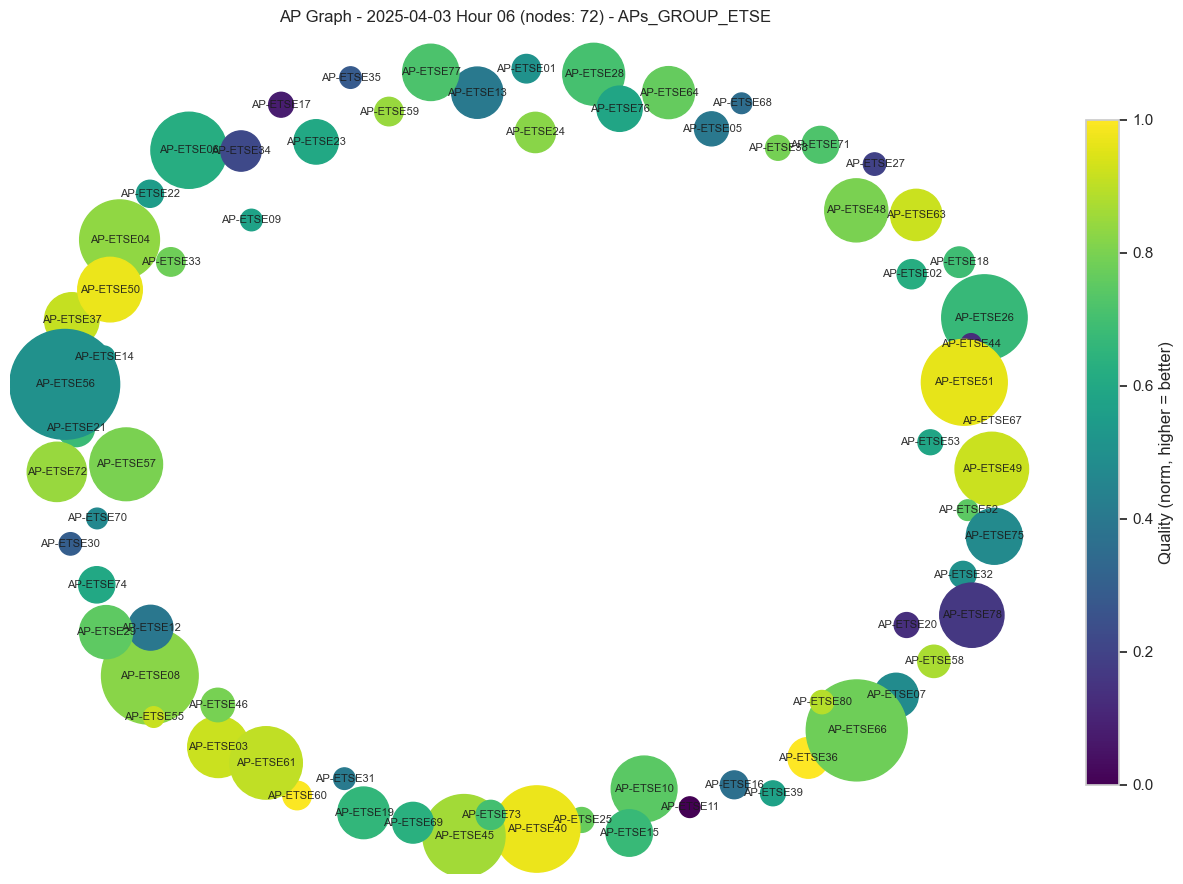

In [4]:
# Agrupar per date i hour i iterar (saltar registres amb hour NaN)
groups = df_clients.dropna(subset=['hour']).groupby(['date', 'hour'])
print(f'Found {len(groups)} date-hour groups')

# Filtre opcional per proves (descomenta per limitar)
# groups = [(d,h,grp) for (d,h), grp in groups if str(d) == '2025-04-03' and h in [8]]

pbar = tqdm(list(groups), desc='Processing date-hour')
created = []
for (date_val, hour_val), grp in pbar:
    date_str = str(date_val)

    # =============================================
    # 1) IMATGE DE GRUPS (agrupació per nom seguint criteri group_analysis)
    # Criteri: extreure prefix del nom (entre 'AP-' i primer dígit) per definir el grup.
    # Exemple: 'AP-VET71' -> grup 'VET'; 'AP-ENG12' -> grup 'ENG'
    # =============================================
    import re
    def extract_group(ap_name):
        if not isinstance(ap_name, str):
            return None
        m = re.match(r'^AP-([A-Za-z]+)', ap_name)
        return m.group(1) if m else None

    grp_copy = grp.copy()
    grp_copy['group_code'] = grp_copy[AP_NAME_COL].apply(extract_group)
    grp_groups = grp_copy.dropna(subset=['group_code'])

    if not grp_groups.empty:
        # Agregar per grup (nodes = grups)
        metrics_group = (grp_groups.groupby('group_code')
                                   .agg(conn_count=('macaddr', 'count'), avg_signal_db=('signal_db', 'mean'))
                                   .reset_index()
                                   .rename(columns={'group_code': AP_NAME_COL}))
        # Construir graf de grups reutilitzant la funció (group_level=True amb buildings ja fa agregació, però aquí fem manual)
        # Per mantenir coherència, creem un df temporal amb la mateixa estructura esperada: AP_NAME_COL + macaddr + signal_db
        df_for_groups = grp_groups.copy()
        df_for_groups[AP_NAME_COL] = df_for_groups['group_code']
        out_groups = build_graph_and_plot(df_for_groups, OUT_DIR, date_str, hour_val, nodes_filter=metrics_group[AP_NAME_COL].tolist(), prefix='GROUPS', group_level=False)
        if out_groups is not None:
            created.append(str(out_groups))

        # =============================================
        # 2) IMATGE PER A CADA GRUP (nodes = APs d'aquest grup)
        # =============================================
        for group_code, sub_df in grp_groups.groupby('group_code'):
            aps_in_group = sub_df[AP_NAME_COL].dropna().unique().tolist()
            if not aps_in_group:
                continue
            out_group_detail = build_graph_and_plot(grp, OUT_DIR, date_str, hour_val, nodes_filter=aps_in_group, prefix=f'APs_GROUP_{group_code}', group_level=False)
            if out_group_detail is not None:
                created.append(str(out_group_detail))
    else:
        # Si no hi ha cap grup identificable, igualment podem intentar una agregació simple per edificis/BUILDINGS
        out_build = build_graph_and_plot(grp, OUT_DIR, date_str, hour_val, nodes_filter=None, prefix='BUILDINGS_FALLBACK', group_level=True)
        if out_build is not None:
            created.append(str(out_build))

print('Done. Created', len(created), 'images. Example:', created[:6])

---
Notes:
- Ajusta la funció `build_graph_and_plot` si vols una combinació diferent de pesos entre `avg_signal_db` i `conn_count`.
- Si vols una única mètrica composta (p.ex. `quality * log(conn_count)`), la pots afegir fàcilment abans de traçar.


## Visualització geogràfica de GROUPS
Mapa interactiu amb els grups (prefix del nom de l'AP) a partir de les coordenades dels APs en `realData/geoloc/aps_geolocalizados_wgs84.geojson`.
Cada punt representa el centroid dels APs del grup; la mida reflecteix el nombre de connexions i el color la qualitat mitjana.

In [7]:
# Carregar geojson de APs i construir dataframe de grups amb coordenades centroid
import geopandas as gpd
import folium
from folium import Map, CircleMarker
from pathlib import Path
GEOJSON_FILE = Path('../realData/geoloc/aps_geolocalizados_wgs84.geojson')
gdf_geo = gpd.read_file(GEOJSON_FILE)
print('Geojson carregat:', len(gdf_geo))

# Extraure prefix de nom (mateix criteri extract_group)
import re
def extract_group(ap_name):
    if not isinstance(ap_name, str):
        return None
    m = re.match(r'^AP-([A-Za-z]+)', ap_name)
    return m.group(1) if m else None

# Necessitem map entre nom AP i (lat, lon)
# El geojson té columna USER_NOM_A amb nom original
geo_cols = ['USER_NOM_A','geometry']
gdf_sub = gdf_geo[geo_cols].dropna(subset=['geometry']).copy()
gdf_sub['group_code'] = gdf_sub['USER_NOM_A'].apply(extract_group)
gdf_sub = gdf_sub.dropna(subset=['group_code'])
print('APs amb group_code:', len(gdf_sub))

# Centroid per grup (lat, lon) i recompte d'APs
group_geo = (
    gdf_sub.groupby('group_code')
            .agg(num_aps=('USER_NOM_A','count'),
                 lat=('geometry', lambda x: x.y.mean()),
                 lon=('geometry', lambda x: x.x.mean()))
            .reset_index()
 )
print('Grups trobats:', len(group_geo))

# Afegir mètriques agregades dels clients si existeixen en df_clients (ja carregat abans)
if 'associated_device_name' in df_clients.columns:
    df_clients['group_code'] = df_clients[AP_NAME_COL].apply(extract_group)
    metrics_groups = (
        df_clients.dropna(subset=['group_code'])
                  .groupby('group_code')
                  .agg(conn_count=('macaddr','count'), avg_signal_db=('signal_db','mean'))
                  .reset_index()
    )
    group_geo = group_geo.merge(metrics_groups, on='group_code', how='left')
else:
    group_geo['conn_count'] = None
    group_geo['avg_signal_db'] = None

# Normalitzar qualitat si disponible
if 'avg_signal_db' in group_geo.columns and group_geo['avg_signal_db'].notna().any():
    vals = group_geo['avg_signal_db']
    mn, mx = vals.min(), vals.max()
    if mx - mn > 0:
        group_geo['quality_norm'] = (vals - mn)/(mx - mn)
    else:
        group_geo['quality_norm'] = 0.5
else:
    group_geo['quality_norm'] = 0.5

group_geo.head()

Geojson carregat: 958
APs amb group_code: 958
Grups trobats: 43


,group_code,num_aps,lat,lon,conn_count,avg_signal_db,quality_norm
0,AMICSUAB,2,41.499748,2.094599,1128.0,-62.383760,0.757389
1,AULAJ,28,41.499595,2.105823,60592.0,-56.122539,1.000000
2,BIBCIE,6,41.500224,2.107757,35386.0,-63.042343,0.731871
3,BIBHUM,14,41.504342,2.106436,32379.0,-61.636604,0.786340
4,BIBSOC,10,41.501516,2.105818,45895.0,-63.862085,0.700107


In [ ]:
# Funció per construir un mapa de GROUPS per un bloc (date-hour) concret
def build_groups_map_for_df(df_hour, gdf_geo, out_dir, date_str, hour):
    import pandas as pd
    from pathlib import Path
    # Preparar dades de grups des del df_hour
    dfh = df_hour.copy()
    dfh['group_code'] = dfh[AP_NAME_COL].apply(extract_group)
    dfh = dfh.dropna(subset=['group_code'])
    if dfh.empty:
        return None
    # Mètriques per grup
    metrics_groups = (
        dfh.groupby('group_code')
           .agg(conn_count=('macaddr','count'), avg_signal_db=('signal_db','mean'))
           .reset_index()
    )
    # Coordenades dels APs presents en df_hour
    ap_names = dfh[AP_NAME_COL].dropna().unique().tolist()
    gdf_sub = gdf_geo[gdf_geo['USER_NOM_A'].isin(ap_names)].copy()
    gdf_sub['group_code'] = gdf_sub['USER_NOM_A'].apply(extract_group)
    gdf_sub = gdf_sub.dropna(subset=['group_code'])
    if gdf_sub.empty:
        return None
    # Centroid per grup amb APs presents
    group_geo = (
        gdf_sub.groupby('group_code')
                .agg(num_aps=('USER_NOM_A','count'),
                     lat=('geometry', lambda x: x.y.mean()),
                     lon=('geometry', lambda x: x.x.mean()))
                .reset_index()
    )
    group_geo = group_geo.merge(metrics_groups, on='group_code', how='left')
    # Normalitzar qualitat si disponible (vectorial)
    if 'avg_signal_db' in group_geo.columns and group_geo['avg_signal_db'].notna().any():
        vals = group_geo['avg_signal_db']
        mn, mx = vals.min(), vals.max()
        if mx - mn > 0:
            group_geo['quality_norm'] = (vals - mn)/(mx - mn)
        else:
            group_geo['quality_norm'] = 0.5
    else:
        group_geo['quality_norm'] = 0.5
    # Construir mapa
    if group_geo.empty:
        return None
    center_lat = group_geo['lat'].mean()
    center_lon = group_geo['lon'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=15, tiles='OpenStreetMap')
    max_conn = group_geo['conn_count'].max() if group_geo['conn_count'].notna().any() else None
    # Iterar i afegir cercles
    for _, row in group_geo.iterrows():
        base_size = row['num_aps'] * 2
        conn = row.get('conn_count')
        if max_conn and not pd.isna(conn) and max_conn > 0:
            size = base_size + (conn / max_conn) * 8
        else:
            size = base_size
        # Sanejar qualitat
        q_raw = row.get('quality_norm', 0.5)
        if pd.isna(q_raw):
            q = 0.5
        else:
            try:
                q = float(q_raw)
            except Exception:
                q = 0.5
        # Clamp [0,1]
        if q < 0: q = 0.0
        if q > 1: q = 1.0
        # Gradient invertit des de vermell (0) -> groc (0.5) -> verd (1)
        if q <= 0.5:
            # 0: vermell pur (#ff0000) -> 0.5: groc (#ffff00)
            ratio = q / 0.5
            r = 255
            g = int(0 + ratio * 255)
            b = 0
        else:
            # 0.5: groc (#ffff00) -> 1: verd (#00ff00)
            ratio = (q - 0.5) / 0.5
            r = int(255 - ratio * 255)
            g = 255
            b = 0
        r = max(0, min(255, r))
        g = max(0, min(255, g))
        b = max(0, min(255, b))
        color_hex = f'#{r:02x}{g:02x}{b:02x}'
        try:
            hour_int = int(hour)
            hour_label = f"{hour_int:02d}"
        except Exception:
            hour_label = str(hour)
        popup_html = f"""<div style='font-family:Arial; font-size:12px;'>"""\
            + f"<b>Group: {row['group_code']}</b><br>"\
            + f"APs al grup: {row['num_aps']}<br>"\
            + (f"Connexions hora: {int(conn)}<br>" if not pd.isna(conn) else "")\
            + (f"Avg Signal (dBm): {row.get('avg_signal_db'):.1f}<br>" if not pd.isna(row.get('avg_signal_db')) else "")\
            + f"Qualitat norm: {q:.2f}" + "</div>"
        CircleMarker(location=[row['lat'], row['lon']],
                     radius=max(size, 4),
                     popup=folium.Popup(popup_html, max_width=280),
                     color=color_hex, fill=True, fillColor=color_hex, fillOpacity=0.75, weight=2).add_to(m)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"{date_str}_hour_{hour_label}_GROUPS_map.html"
    m.save(str(out_file))
    return out_file

In [9]:
# Generar un mapa GROUPS per a cada bloc date-hour (opcionalment limitable)
# Filtre opcional per proves (descomenta per limitar la data/hora)
# target_dates = {'2025-04-03'}
groups_it = df_clients.dropna(subset=['hour']).groupby(['date','hour'])
created_maps = []
for (date_val, hour_val), grp in tqdm(list(groups_it), desc='Building GROUPS maps'):
    date_str = str(date_val)
    # if date_str not in target_dates:
    #     continue
    out_map = build_groups_map_for_df(grp, gdf_geo, OUT_DIR, date_str, hour_val)
    if out_map is not None:
        created_maps.append(str(out_map))
print('Done. GROUPS maps created:', len(created_maps))
created_maps[:5]

Building GROUPS maps: 100%|██████████| 207/207 [00:37<00:00,  5.56it/s]

Done. GROUPS maps created: 204


['pabloCalo/output/hourly_graphs/2025-03-28_hour_12_GROUPS_map.html',
 'pabloCalo/output/hourly_graphs/2025-03-28_hour_13_GROUPS_map.html',
 'pabloCalo/output/hourly_graphs/2025-03-31_hour_00_GROUPS_map.html',
 'pabloCalo/output/hourly_graphs/2025-03-31_hour_06_GROUPS_map.html',
 'pabloCalo/output/hourly_graphs/2025-03-31_hour_10_GROUPS_map.html']